# Creating vanishing Gradient situation

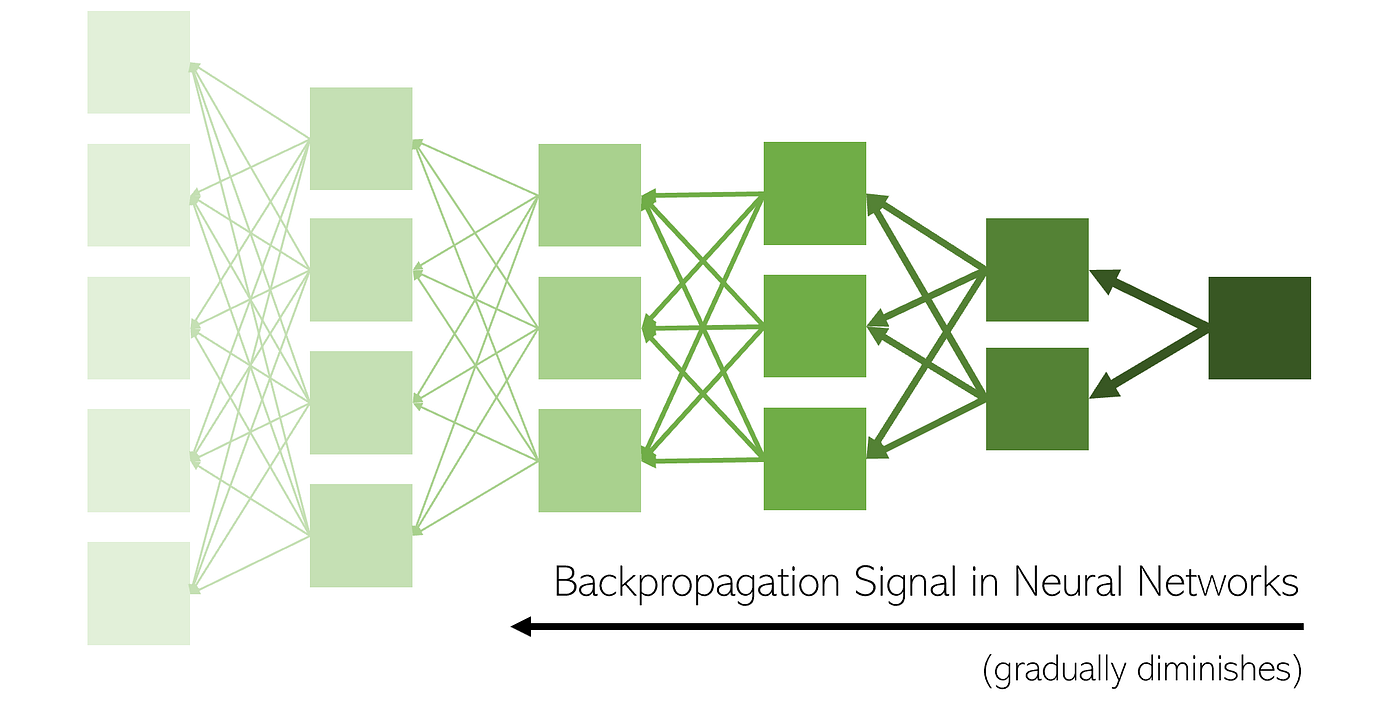

- The vanishing gradient problem is a challenge that arises during the training of deep neural networks, particularly those with many layers. It occurs when the gradients of the loss function with respect to the model's parameters (weights) become extremely small as they are backpropagated from the output layer to the earlier layers of the network. As a result, the weights in the early layers are updated very slowly or not updated at all, impeding the learning process.

- One important characteristic of the sigmoid function's derivative is that as the input (x) becomes very large or very small, the derivative approaches 0. This phenomenon is known as the "vanishing gradient" problem. It can hinder the learning process in deep neural networks, making it challenging for the network to update weights in earlier layers effectively.

⚠️ Warning:
- We have use two activation function in a single layer which may never happens in reality.
- The purposes of this notebook are:
    - how weight initialization affects the model training process
    - provide the reason of how sigmoid activation causes vanishing gradient problem in deep neural network
    - how we can analyze and understand the model results

### Prerequesits
- I assume you already have checked out my MultiClassLogisticRegression using tensorflow core notebook

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

2023-07-21 20:07:31.443000: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 20:07:31.632957: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-21 20:07:31.634572: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-21 20:07:32.729133: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SEED = 4 # if you want different result you can change the seed value
tf.random.set_seed(SEED)

# Load Data

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

In [4]:
print("x_train shape: ",x_train.shape)
print("y_train shape: ", y_train.shape)
print("x_test shape: ", x_test.shape)
print("y_test shape: ", y_test.shape)

x_train shape:  (60000, 28, 28)
y_train shape:  (60000,)
x_test shape:  (10000, 28, 28)
y_test shape:  (10000,)


In [5]:
NUM_CLASSES = len(np.unique(y_train))
print(f"There are {NUM_CLASSES} unique classes in this dataset")

There are 10 unique classes in this dataset


In [6]:
x_train = tf.reshape(x_train, shape=(x_train.shape[0], -1))
x_test = tf.reshape(x_test, shape=(x_test.shape[0], -1))

2023-07-21 20:07:34.465307: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47040000 exceeds 10% of free system memory.


In [7]:
x_train = tf.cast(tf.transpose(x_train), "float32")
x_test = tf.cast(tf.transpose(x_test), "float32")
y_train = tf.constant(y_train)
print("New x_train shape: ", x_train.shape)
print("New x_test shape: ", x_test.shape)

New x_train shape:  (784, 60000)
New x_test shape:  (784, 10000)


2023-07-21 20:07:34.518969: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47040000 exceeds 10% of free system memory.
2023-07-21 20:07:34.555155: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.
2023-07-21 20:07:34.640057: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 31360000 exceeds 10% of free system memory.


In [8]:
# Normalizing
x_train = x_train/255.
x_test = x_test/255.

2023-07-21 20:07:34.659626: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 188160000 exceeds 10% of free system memory.


In [9]:
tf.reduce_min(x_train).numpy(), tf.reduce_max(x_test).numpy()

(0.0, 1.0)

# Activation Functions

In [10]:
def softmax(x):
    max_logits = tf.reduce_max(x, axis=0, keepdims=True)
    # this line is essential, it helps to scale down the y_pred
    ex_x = tf.math.exp(x - max_logits)
    sum_ex = tf.reduce_sum(ex_x, axis=0, keepdims=True)
    softmax_x = ex_x / (sum_ex)
    return softmax_x

In [11]:
def sigmoid(z):
    exp_z = tf.math.exp(-z)
    return 1 / (1 + exp_z)

# Loss Function

In [12]:
def sparse_categorical_crossentropy_loss(y_true, y_pred, from_logits=False):
    if from_logits:
        y_pred = softmax(y_pred)
    #here depth parameter takes number of features/classes    
    one_hot_y_true = tf.transpose(tf.one_hot(y_true, depth=y_pred.shape[0])) 
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
    log_y_pred = tf.math.log(y_pred)
    mul = tf.multiply(one_hot_y_true, log_y_pred)    
    losses = -tf.reduce_sum(mul, axis=0)
    return tf.reduce_mean(losses)

# Model

In [13]:
class MultiClassLogisticRegression(tf.Module):
    def __init__(self, n_classes, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.is_built = False
        self.n_class = n_classes
    
    def build(self, num_features):
        # randomly generate bias and weights
        self.weights = tf.Variable(tf.random.uniform([self.n_class, num_features]), name="weights")
        self.bias = tf.Variable(tf.zeros([self.n_class, 1]), name="bias")
        print("built successfully")
        
    def predict(self, x):
        #compute model output
        # compute logits
        logits = self.weights @ x + self.bias
        # we are passing logits intentionally through the sigmoid function just to cause a vanishing gradient
        sigmoid_out = sigmoid(logits)
        pred = softmax(sigmoid_out)
        return pred
    
    def __call__(self, x):
        if not self.is_built:
            self.build(x.shape[0])
            self.is_built = True
        return self.predict(x)

In [14]:
model = MultiClassLogisticRegression(10)
output = model(x_train[:, :10])
output.shape, output[:, 0]

built successfully


(TensorShape([10, 10]),
 <tf.Tensor: shape=(10,), dtype=float32, numpy=array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], dtype=float32)>)

# Train Function

In [15]:
# defining training function
def train(model, x_train, y_train, learning_rate=0.01):
    loss = 0
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        loss = sparse_categorical_crossentropy_loss(y_train, y_pred)
        
    dw, db = tape.gradient(loss, [model.weights, model.bias])
    
    # applying batch gradient descent 
    # w = w - lr * dloss/dw
    model.weights.assign_sub(learning_rate * dw)
    model.bias.assign_sub(learning_rate * db)
    return loss

# Training Loop

In [16]:
def display_training_summary(loss, epoch):
    print(f"EPOCH: {epoch} --- loss: {loss}")

In [17]:
# sample train data, let's only use the first 10K dataset only
x_train_sample = x_train[:, :10_000]
y_train_sample = y_train[:10_000]

In [18]:
# to store loss and accuracy from each epoch
LOSS_HISTORY = []
# instantiate the model
model = MultiClassLogisticRegression(NUM_CLASSES)

In [19]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.1

#  Training Loop
for epoch in range(NUM_EPOCHS):
    loss = train(model, x_train_sample, y_train_sample, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    display_training_summary(loss, epoch+1)

built successfully
EPOCH: 1 --- loss: 2.3025825023651123
EPOCH: 2 --- loss: 2.3025825023651123
EPOCH: 3 --- loss: 2.3025825023651123
EPOCH: 4 --- loss: 2.3025825023651123
EPOCH: 5 --- loss: 2.3025825023651123
EPOCH: 6 --- loss: 2.3025825023651123
EPOCH: 7 --- loss: 2.3025825023651123
EPOCH: 8 --- loss: 2.3025825023651123
EPOCH: 9 --- loss: 2.3025825023651123
EPOCH: 10 --- loss: 2.3025825023651123


Here you can clearly see we are getting a constant loss. Let's figure out what is happening here.

# Reason Analysis

In order to make the analysis progressive we are going to copy above code/functions and print what is happining in there.

# Part 1

In [20]:
# defining training function
def train(model, x_train, y_train, learning_rate=0.01):
    loss = 0
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        loss = sparse_categorical_crossentropy_loss(y_train, y_pred)
        
    dw, db = tape.gradient(loss, [model.weights, model.bias])
    
    print("Min gradient of loss wrt weight (dL/dw) :", tf.reduce_min(dw).numpy())
    print("Average gradient of loss wrt weight (dL/dw) :", tf.reduce_mean(dw).numpy())
    print("Max gradient of loss wrt weight (dL/dw) :", tf.reduce_max(dw).numpy())
    
    # applying batch gradient descent 
    # w = w - lr * dloss/dw
    model.weights.assign_sub(learning_rate * dw)
    model.bias.assign_sub(learning_rate * db)
    return loss

In [21]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.1

#  Training Loop
for epoch in range(NUM_EPOCHS):
    loss = train(model, x_train_sample, y_train_sample, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    display_training_summary(loss, epoch+1)

Min gradient of loss wrt weight (dL/dw) : -1.1801454e-08
Average gradient of loss wrt weight (dL/dw) : -2.2268156e-11
Max gradient of loss wrt weight (dL/dw) : 1.6842961e-09
EPOCH: 1 --- loss: 2.3025825023651123
Min gradient of loss wrt weight (dL/dw) : -1.1801454e-08
Average gradient of loss wrt weight (dL/dw) : -2.2268156e-11
Max gradient of loss wrt weight (dL/dw) : 1.6842961e-09
EPOCH: 2 --- loss: 2.3025825023651123
Min gradient of loss wrt weight (dL/dw) : -1.1801454e-08
Average gradient of loss wrt weight (dL/dw) : -2.2268156e-11
Max gradient of loss wrt weight (dL/dw) : 1.6842961e-09
EPOCH: 3 --- loss: 2.3025825023651123


- Let's analyse what is happining here:
    - we can clearly see that the minimum, maximum and average value of the gradient (dw) is same in every epochs, we can conclude that we are getting same gradient wrt weights in each epoch.
   - Also we can see that gradient values are so small, even the maximum gradient is approximately zero.

- We know that gradient descent works by subtracting lr*gardient from the weight.
    - Mathematically , 
        W = W - lr * grad
    - Here lr * grad is approximately zere, causing W = W - 0, causing no changes in the weight in each epoch. 
- Since there is no change is weights, we are getting the same loss and thus same gradients.

Here we have found, why we are getting the same loss in each epoch. Now let's analyse why we are getting approx. zero gradient.

**Note that this zero gradient situation is commonly known as vanishining gradient problem**

# Part 2

Now, this time we are going the trace the initial weights, logits, sigmoid_out and softmax_out.

In [70]:
class MultiClassLogisticRegression(tf.Module):
    def __init__(self, n_classes, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.is_built = False
        self.n_class = n_classes
    
    def build(self, num_features):
        # randomly generate bias and weights
        self.weights = tf.Variable(tf.random.uniform([self.n_class, num_features]), name="weights")
        self.bias = tf.Variable(tf.zeros([self.n_class, 1]), name="bias")
        print("build successfully")
        
    def predict(self, x):
        #compute model output
        # compute logits
        logits = self.weights @ x + self.bias
        # Instead of analysing the entire batch result, for simplicity we are going to analyze the single example 
        print("Logits: ", logits[:, 0].numpy())
        sigmoid_out = sigmoid(logits)
        print("Sigmoid out: ", sigmoid_out[:, 0].numpy())
        pred = softmax(sigmoid_out)
        print("softmax out: ",pred[:, 0].numpy())
        return pred
    
    def __call__(self, x):
        if not self.is_built:
            self.build(x.shape[0])
            self.is_built = True
        return self.predict(x)

In [71]:
NUM_EPOCHS = 3
LEARNING_RATE = 0.1

model = MultiClassLogisticRegression(10)
#  Training Loop
for epoch in range(NUM_EPOCHS):
    loss = train(model, x_train_sample, y_train_sample, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    display_training_summary(loss, epoch+1)
    print("======================")
    print("")

build successfully
Logits:  [53.93479  57.809128 53.356766 50.55593  55.774372 57.431915 56.567352
 55.649246 51.899406 54.520638]
Sigmoid out:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
softmax out:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Min gradient of loss wrt weight (dL/dw) : -5.328609e-09
Average gradient of loss wrt weight (dL/dw) : -3.1865112e-12
Max gradient of loss wrt weight (dL/dw) : 1.0699627e-09
EPOCH: 1 --- loss: 2.3025825023651123

Logits:  [53.93479  57.809128 53.356766 50.55593  55.774372 57.431915 56.567352
 55.649246 51.899406 54.520638]
Sigmoid out:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
softmax out:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Min gradient of loss wrt weight (dL/dw) : -5.328609e-09
Average gradient of loss wrt weight (dL/dw) : -3.1865112e-12
Max gradient of loss wrt weight (dL/dw) : 1.0699627e-09
EPOCH: 2 --- loss: 2.3025825023651123

Logits:  [53.93479  57.809128 53.356766 50.55593  55.774372 57.431915 56.567352
 55.649246 51.899406 54.520638]
Sigmoid out:  [1.

Before analyzing above result, let's understand about sigmoid function
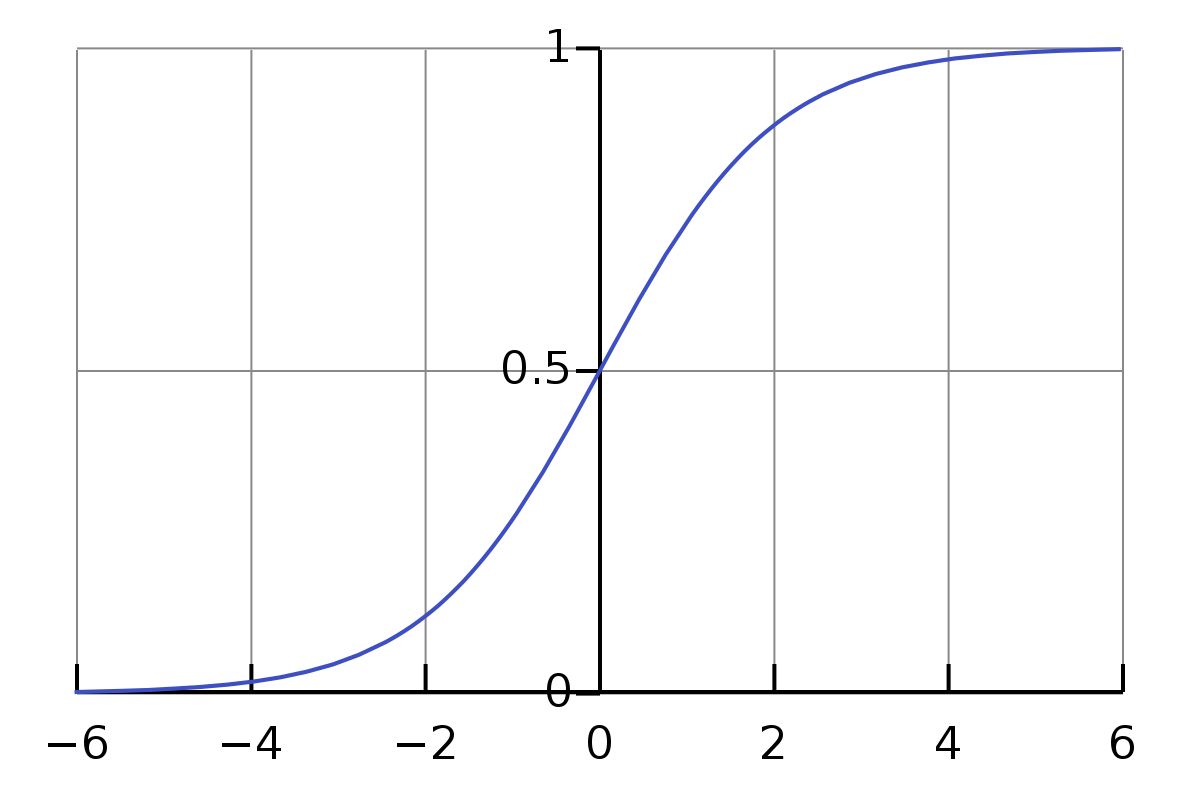

Sigmoid basically transforms any value in the domain to a number between 0 and 1.

In [26]:
sigmoid(tf.constant([-2., 0., 10., 20., 30.]))

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([0.11920292, 0.5       , 0.9999546 , 1.        , 1.        ],
      dtype=float32)>

As you can see
    - value -2 is mapped to 0.12
    - Value 0 is mapped to 0.5
    - value greater that 10. is mapped to 1.

- In above result, we can clearly see that logits are greater than 50. Thus, when we apply sigmoid function in that logits every value got transformed to one. 
- Since, every values are same i.e 1., their probability transformation is also going to be the same. In our case, they have become 0.1 (since, 10 elements are there in each example).

Now let's understand role of the loss function

Here we have,
```
x = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
```
let's assume, one-hot encoding of y_true be
```
y = [1, 0, 0, 0, 0, 0, 0 ,0, 0, 0 ]
```

let's calculate loss,
```
loss = - 1*log(0.1)
```

In [27]:
1 * tf.math.log(tf.constant(0.1)).numpy()

-2.3025851249694824

```
loss = 2.30258
```
Since, this loss is exactly the same cost value(batch loss which is the average of individual example loss) we are getting. We can say that each individual example loss is approx. 2.30258.

# Part 3

Now, let's understand why we are getting gradients equal to zero. 

**Note We are not going to derive the backpropagation but we are going to used the already derived formula, if you want to know you can visit http://cs230.stanford.edu/fall2018/section_files/section3_soln.pdf.**

**Recall that backpropagation uses chain rule:**
```
dl/dw = dl/d(softmax) * d(softmax)/d(sigmoid) * d(sigmoid)/d(y_pred) * d(y_pred)/dw
```


We are going to use gradient tape to do auto differentiation and this time we are going to analyze the intermediate results.

In [28]:
w = tf.Variable(tf.random.uniform([10, 28*28]))
x = x_train_sample[:, :2]
y_true = y_train_sample[:2]
with tf.GradientTape(persistent=True) as tape:
    y_pred = w @ x
    sigmoid_out = sigmoid(y_pred)
    softmax_out = softmax(sigmoid_out)
    loss = sparse_categorical_crossentropy_loss(y_true, softmax_out)

In [29]:
loss

<tf.Tensor: shape=(), dtype=float32, numpy=2.3025851>

In [30]:
def print_stat(tensor):
    try:
        print("Min value: ", tf.reduce_min(tensor, axis=-1).numpy())
        print("Avg value: ", tf.reduce_mean(tensor, axis=-1).numpy())    
        print("Max value: ", tf.reduce_max(tensor, axis=-1).numpy())   
    except Exception as e:
        print("tensor: None",)

In [31]:
# d(y_pred)/d(w)
result = tape.gradient(y_pred, w)
print(result.shape)
print_stat(result)

(10, 784)
Min value:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Avg value:  [0.2932173 0.2932173 0.2932173 0.2932173 0.2932173 0.2932173 0.2932173
 0.2932173 0.2932173 0.2932173]
Max value:  [1.9843137 1.9843137 1.9843137 1.9843137 1.9843137 1.9843137 1.9843137
 1.9843137 1.9843137 1.9843137]


In [32]:
# d(sigmoid_out)/d(y_pred)
result = tape.gradient(sigmoid_out, y_pred)
print_stat(result)

Min value:  [8.5851048e-29 2.9011842e-26 3.4120037e-28 5.9365350e-27 7.9169120e-28
 4.2034072e-27 1.4611000e-28 3.2636404e-28 2.8538295e-27 1.3194766e-26]
Avg value:  [1.2479166e-23 6.8177733e-25 1.5575812e-27 1.1798139e-22 1.8007183e-23
 1.6267891e-23 7.2737122e-25 1.8988879e-25 7.5729064e-25 3.9835724e-24]
Max value:  [2.4958246e-23 1.3345428e-24 2.7739620e-27 2.3595685e-22 3.6013573e-23
 3.2531579e-23 1.4545963e-24 3.7945122e-25 1.5117275e-24 7.9539504e-24]


If you look closely, the above values are approximately zero.

In [33]:
# d(softmax_out)/d (sigmoid_out)
result = tape.gradient(softmax_out, sigmoid_out)
print_stat(result)

Min value:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Avg value:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Max value:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [34]:
#  d(loss)/d(softmax_out)
result = tape.gradient(loss, softmax_out)
print_stat(result)

Min value:  [-5. -0. -0. -0. -0. -5. -0. -0. -0. -0.]
Avg value:  [-2.5  0.   0.   0.   0.  -2.5  0.   0.   0.   0. ]
Max value:  [-0. -0. -0. -0. -0. -0. -0. -0. -0. -0.]


We know that, 
```
dl/dw = dl/d(softmax_out) * d(softmax)/d(sigmoid_out) * d(sigmoid_out)/d(y_pred) * d(y_pred)/dw

```
since, d(softmax_out)/d(sigmoid_out) == 0 and/or d(sigmoid_out)/d(y_pred) == 0. we will get dl/dw = 0, regardless of other gradients value in the chain.

# Part 4

Till now, we know that why we are getting gradient of loss with respect to weights is zero.
Now, it's time to analyzing why d(sigmoid_out)/d(y_pred) and/or d(softmax_out)/d(sigmoid_out) is zero.

Image below shows the sigmoid function along with its derivative.
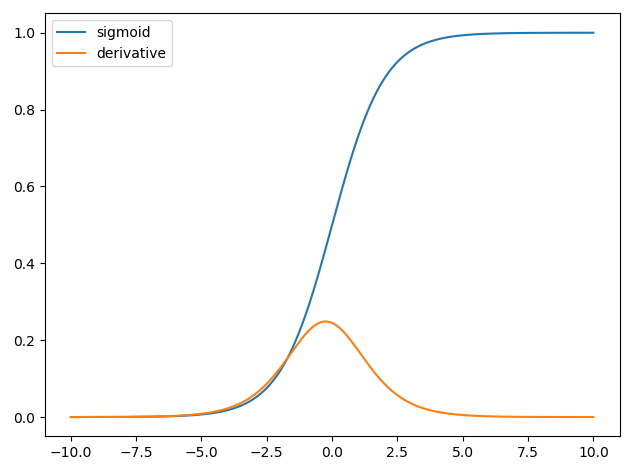

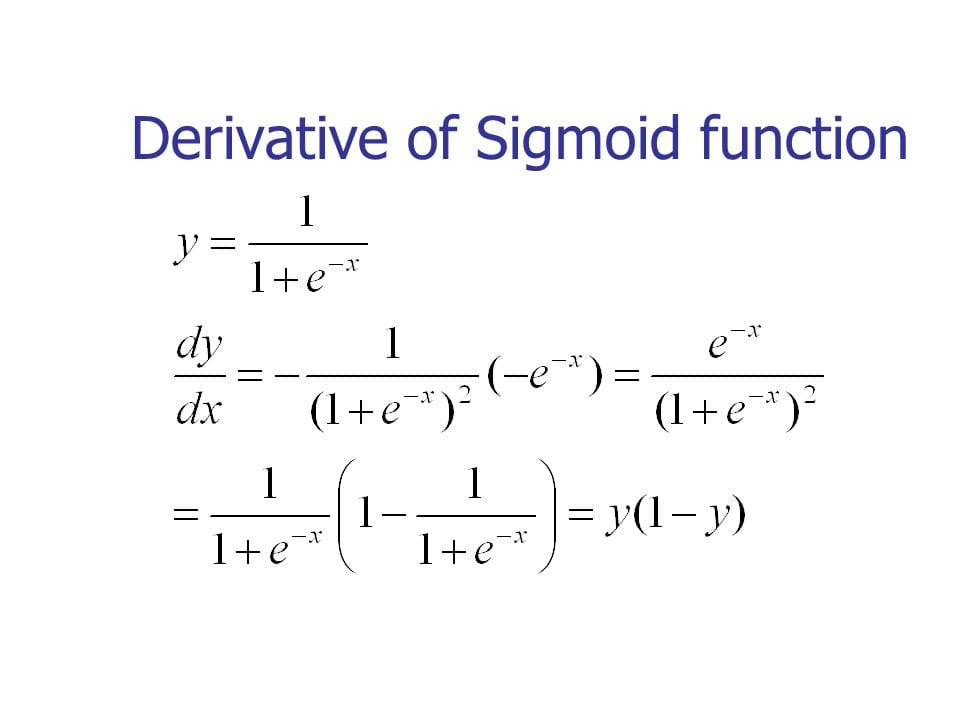

Previously, we have seen that:
- Logits:  [55.522034 51.906357 55.13922  53.51525  53.60176  54.736485 54.15336
 54.27411  47.27482  48.65992 ]
- Sigmoid out:  [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
- softmax out:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

We can interprete above curve as , when sigmoid value is 0.5, it's derivative will be maximum i.e 0.25 and when you increase or decrease the sigmoid value from 0.5 the derivative will tend to zero. 


We can also verify it through that derivative formula.

In [39]:
# when y = 1
1 * (1  - 1) 

0

In [40]:
# when y = 0.5
0.5*(1 - 0.5)

0.25

In [41]:
#when y=0.3
0.3*(1-0.3)

0.21

As you can see, the every sigmoid output value is 1, thus we are getting its derivative zero.

# Finding the root cause

- Why we are getting sigmoid value 1, because the input to the sigmoid value is very large or let's say it is greater than 10 or less than -10.
- And the input the the sigmoid function is a weighted sum i.e
   ```
   z = x1*w1 + x2*w2 + x3*w3..+b
   ```
- Since we have normalized input x whose value ranges from 0 to 1. 
- So the only parameter that is responsible for the larger z value is weights.


In [44]:
# we use random uniform values as an initial weight
weights = tf.Variable(tf.random.uniform([1, 10]), name="weights")
# whereas we set bias zero, so initial bias value are not playing any role for the high z value.
bias = tf.Variable(tf.zeros([1, 1]), name="bias")

In [50]:
weights.numpy()

array([[ 0.1406809 ,  1.4999164 ,  0.776991  ,  0.18761054,  0.13724385,
        -0.27381796, -0.5744998 ,  0.67509335,  0.5632125 ,  0.20523494]],
      dtype=float32)

- When we set uniform random value, the initial weights ranges from 0 to 1.
- since, we have  28*28 = 784 input features, upon performation summation we will get large value.
- So, to overcome this proble, we can set initial weights ranges from negative values to positive value.
- For this, we can set random values from normal distribution where mean = 0 and std =1 (this is a default value, upon changing may also works)

In [51]:
# we use random values from normal distribution as an initial weight
weights = tf.Variable(tf.random.normal([1, 10]), name="weights")

In [52]:
weights.numpy()

array([[-0.25013578, -0.8873382 ,  0.1611341 ,  0.64176583,  1.3921583 ,
        -0.12301864, -0.82026315, -1.063403  ,  0.30391407, -1.3649781 ]],
      dtype=float32)

# Changing weight initialization strategy
Let's change the initial weight as random.normal, and set we have resolved the vanishing gradient problem or not.

In [59]:
class MultiClassLogisticRegression(tf.Module):
    def __init__(self, n_classes, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.is_built = False
        self.n_class = n_classes
    
    def build(self, num_features):
        # randomly generate bias and weights
        self.weights = tf.Variable(tf.random.normal([self.n_class, num_features]), name="weights")
        self.bias = tf.Variable(tf.zeros([self.n_class, 1]), name="bias")
        
    def predict(self, x):
        #compute model output
        # compute logits
        logits = self.weights @ x + self.bias
        # Instead of analysing the entire batch result, for simplicity we are going to analyze the single example 
        sigmoid_out = sigmoid(logits)
        pred = softmax(sigmoid_out)
        return pred
    
    def __call__(self, x):
        if not self.is_built:
            self.build(x.shape[0])
            self.is_built = True
        return self.predict(x)

In [66]:
# defining training function
def train(model, x_train, y_train, learning_rate=0.01):
    loss = 0
    with tf.GradientTape() as tape:
        y_pred = model(x_train)
        loss = sparse_categorical_crossentropy_loss(y_train, y_pred)
        
    dw, db = tape.gradient(loss, [model.weights, model.bias])
    print("Min gradient of loss wrt weight (dL/dw) :", tf.reduce_min(dw).numpy())
    print("Average gradient of loss wrt weight (dL/dw) :", tf.reduce_mean(dw).numpy())
    print("Max gradient of loss wrt weight (dL/dw) :", tf.reduce_max(dw).numpy())
    
    # applying batch gradient descent 
    # w = w - lr * dloss/dw
    model.weights.assign_sub(learning_rate * dw)
    model.bias.assign_sub(learning_rate * db)
    return loss

In [67]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.1

model = MultiClassLogisticRegression(10)
#  Training Loop
for epoch in range(NUM_EPOCHS):
    loss = train(model, x_train_sample, y_train_sample, LEARNING_RATE)
    LOSS_HISTORY.append(loss)
    display_training_summary(loss, epoch+1)

Min gradient of loss wrt weight (dL/dw) : -0.0034280117
Average gradient of loss wrt weight (dL/dw) : -4.878859e-05
Max gradient of loss wrt weight (dL/dw) : 0.0029019695
EPOCH: 1 --- loss: 2.3116602897644043
Min gradient of loss wrt weight (dL/dw) : -0.0034190062
Average gradient of loss wrt weight (dL/dw) : -4.857926e-05
Max gradient of loss wrt weight (dL/dw) : 0.0029011269
EPOCH: 2 --- loss: 2.311371088027954
Min gradient of loss wrt weight (dL/dw) : -0.003410011
Average gradient of loss wrt weight (dL/dw) : -4.8369722e-05
Max gradient of loss wrt weight (dL/dw) : 0.002900281
EPOCH: 3 --- loss: 2.311081886291504
Min gradient of loss wrt weight (dL/dw) : -0.0034010264
Average gradient of loss wrt weight (dL/dw) : -4.8159938e-05
Max gradient of loss wrt weight (dL/dw) : 0.002899432
EPOCH: 4 --- loss: 2.310793399810791
Min gradient of loss wrt weight (dL/dw) : -0.003392054
Average gradient of loss wrt weight (dL/dw) : -4.7949903e-05
Max gradient of loss wrt weight (dL/dw) : 0.00289858

As you can see, we have resolved the vanishing gradient problem, but there are still some problem
- the derivative of sigmoid is too small, the learning process is too slow.
- This is why there are various other activation functions as well as weight initialization strategies.